In [7]:
import os 
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import numpy as np
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
tf.compat.v1.disable_eager_execution() 
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
from data_loader import load_data
from data_preprocesser import preprocess_data
from planar import Planar
from experiment import Experiment
import tensorflow.python.util.deprecation as deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False

In [8]:
def train(session, loss, optimizer, steps=int(1e5)):
    
    """ optimize for all dimensions """
    
    recorded_steps = []
    recorded_losses = []
    for i in range(steps):
        _, loss_per_iteration = session.run([optimizer, loss])
        if i % 100 == 0:
            recorded_steps.append(i)
            recorded_losses.append(loss_per_iteration)
        if i % int(1e4) == 0:
            print('Iteration {iteration}: {loss}'.format(iteration=i,loss=loss_per_iteration))
    return recorded_losses

def plot_results(recorded_losses):
    
    """ plot loss """
    print('Displaying results...')
    fig = plt.figure(figsize=(10,5))
    x = np.arange(len(recorded_losses))
    y = recorded_losses
    m, b = np.polyfit(x, y, 1) 
    plt.scatter(x, y, s=10, alpha=0.3)
    plt.plot(x, m*x+b, c="r")
    plt.title('Loss per 100 iteration')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.tight_layout()
    plt.show()
    
def create_tensor(data, batch_size):
    dataset = tf.data.Dataset.from_tensor_slices(data.astype(np.float32))
    dataset = dataset.repeat()
    dataset = dataset.shuffle(buffer_size=data.shape[0])
    dataset = dataset.prefetch(2*batch_size)
    dataset = dataset.batch(batch_size)
    data_iterator = tf.compat.v1.data.make_one_shot_iterator(dataset)
    samples = data_iterator.get_next()
    return samples

""" 
if any error on tensorflow is displayed claiming tf.float32 is not displayed,
do the following (one of them is probably enough)
    ** downgrade keras to 2.3.1
    ** replace tf.float32 with np.float32
"""
def check_version():    
    print(f'Tensorflow version: {tf.__version__}')
    print(f'Tensorflow-probability version: {tfp.__version__}')
    print(f'Keras version: {tf.keras.__version__}\n')

Data successfully loaded...

Data successfully preprocessed...

Optimizer: Adam_2
Optimizer and loss successfully defined...

Iteration 0: 67.72018432617188
Iteration 10000: 50.87361526489258
Iteration 20000: 49.461578369140625
Iteration 30000: 47.951717376708984
Iteration 40000: 48.37260818481445
Iteration 50000: 50.30542755126953
Iteration 60000: 56.00780487060547
Iteration 70000: 49.113250732421875
Iteration 80000: 52.14418411254883
Iteration 90000: 53.7171630859375
Training finished...

Displaying results...


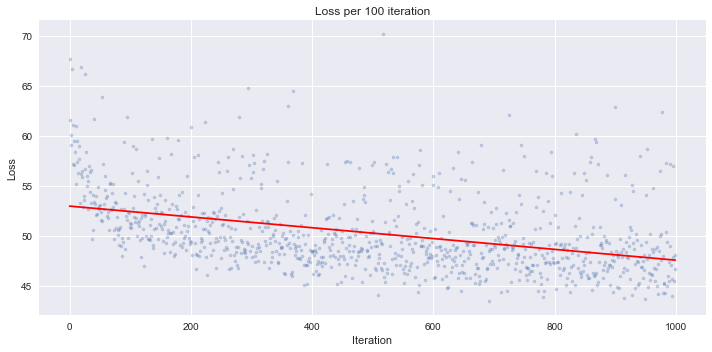

Optimizer: RMSProp_1
Optimizer and loss successfully defined...

Iteration 0: 67.72018432617188
Iteration 10000: 50.327049255371094
Iteration 20000: 49.17314910888672
Iteration 30000: 47.96260070800781
Iteration 40000: 48.530052185058594
Iteration 50000: 50.012115478515625
Iteration 60000: 55.44752502441406
Iteration 70000: 48.46278381347656
Iteration 80000: 50.908756256103516
Iteration 90000: 53.237548828125
Training finished...

Displaying results...


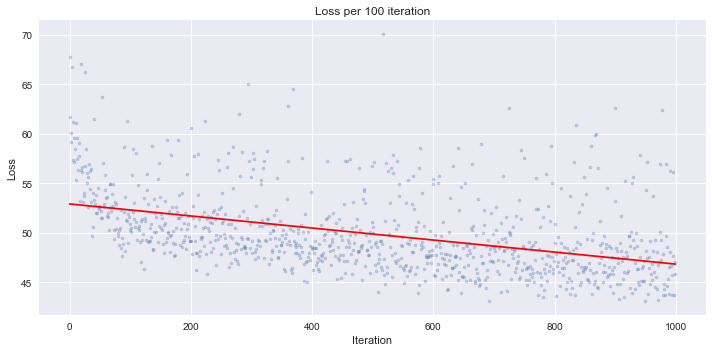

Optimizer: GradientDescent
Optimizer and loss successfully defined...

Iteration 0: 67.72018432617188
Iteration 10000: 52.13264846801758
Iteration 20000: 50.16011047363281
Iteration 30000: 49.20921325683594
Iteration 40000: 50.55030059814453
Iteration 50000: 52.41923522949219
Iteration 60000: 58.27455139160156
Iteration 70000: 50.87456512451172
Iteration 80000: 54.857730865478516
Iteration 90000: 57.00137710571289
Training finished...

Displaying results...


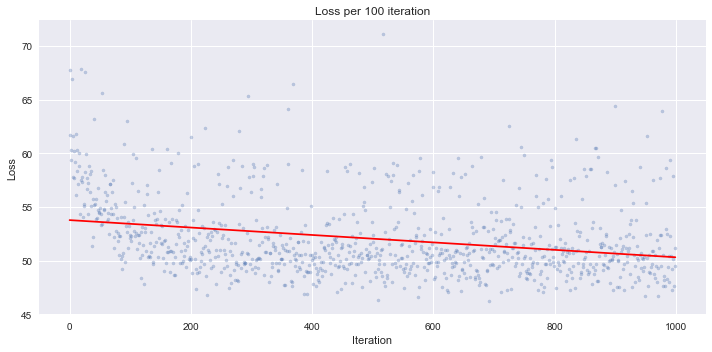

In [9]:
def main():
    
    """ load data """

    filename = 'prostate.xls'
    directory = '/Users/kaanguney.keklikci/Data/'

    loader = load_data(filename, directory)
    loader.create_directory(directory)
    data = loader.read_data(directory, filename)
    print('Data successfully loaded...\n')
    
    """ preprocess data """

    fillna_vals = ['sz', 'sg', 'wt']
    dropna_vals = ['ekg', 'age']
    drop_vals = ['patno', 'sdate']

    preprocesser = preprocess_data(StandardScaler(), fillna_vals, dropna_vals, drop_vals)
    data = preprocesser.dropna_features(data)
    data = preprocesser.impute(data)
    data = preprocesser.drop_features(data)
    data = preprocesser.encode_categorical(data)
    data = preprocesser.scale(data)
    print('Data successfully preprocessed...\n')
    
    """ set Planar parameters """
    
    tfd = tfp.distributions
    tfb = tfp.bijectors

    batch_size = 32
    dtype = np.float32
    # layers should be higher but for comparison fix layers to 2 for every initial test
    layers = 2
    dims = data.shape[1]
    # multivariate normal for base distribution
    base_dist = tfd.MultivariateNormalDiag(loc=tf.zeros(shape=dims, dtype=dtype))
    learning_rate = 1e-4
    steps = int(1e4)
    
    """ initialize samples """
    samples = create_tensor(data, batch_size)
    
    """ make Planar """

    bijectors = []
    for i in range(0, layers):
        bijectors.append(Planar(input_dimensions=dims, case='density_estimation'))
    bijector = tfb.Chain(bijectors=list(reversed(bijectors)), name='chain_of_planar')
    planar_flow = tfd.TransformedDistribution(
        distribution=base_dist,
        bijector=bijector
    )

    loss = -tf.reduce_mean(planar_flow.log_prob(samples))
    optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate).minimize(loss)
    
    experiment = Experiment(optimizer, learning_rate, loss, steps)
    
    keywords = ['adam', 'rmsprop', 'sgd']
    
    for keyword in keywords:

        session = tf.compat.v1.Session()
        tf.compat.v1.set_random_seed(42)
        experiment.change_optimizer(learning_rate, loss, keyword=keyword)
        optimizer = experiment.get_optimizer()
        session.run(tf.compat.v1.global_variables_initializer())
        print(f'Optimizer: {optimizer.name}')
        print('Optimizer and loss successfully defined...\n')

        """ start training """
        recorded_losses = train(session, loss, optimizer)
        print('Training finished...\n')

        """ display results """
        plot_results(recorded_losses)

    
if __name__ == "__main__":
    main()